In [1]:
# ===============================================================
#  FULL INTEGRATED VERSION
#  RF + XGBoost + KNN + SVR (單一 Cell，含訓練 + 推論時間)
# ===============================================================

import pandas as pd
import numpy as np
import time
import os

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# ===============================================================
# Functions
# ===============================================================

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean()) * 100

def load_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    return pd.read_csv(path)

def infer_feature_types(df, target_col):
    cols = [c for c in df.columns if c != target_col]
    numeric = df[cols].select_dtypes(include=[np.number]).columns.tolist()
    categorical = [c for c in cols if c not in numeric]
    return numeric, categorical

def prepare_data(df, target_col):
    df = df.copy()
    df = df.dropna(subset=[target_col])
    numeric, categorical = infer_feature_types(df, target_col)
    X = df[numeric + categorical]
    y = df[target_col].astype(float)

    preproc = ColumnTransformer(
        transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)],
        remainder='passthrough'
    )
    X_enc = preproc.fit_transform(X)
    return X_enc, y, preproc, numeric, categorical

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    train_time = time.perf_counter() - t0
    # Predict
    t1 = time.perf_counter()
    preds = model.predict(X_test)
    predict_time = time.perf_counter() - t1
    # Metrics
    rmse = mean_squared_error(y_test, preds) ** 0.5
    r2 = r2_score(y_test, preds)
    m = mape(y_test, preds)
    return train_time, predict_time, rmse, r2, m

# ===============================================================
# PART 1 — RF + XGB
# ===============================================================

train1 = load_csv("adult_data_no_duplicates.csv")
test1  = load_csv("adult_test_no_duplicates.csv")

df_all_1 = pd.concat([train1, test1], ignore_index=True)
target_col = "hours-per-week"

X_all_1, y_all_1, preproc1, num_cols1, cat_cols1 = prepare_data(df_all_1, target_col)

n_train1 = len(train1)
X_train1 = X_all_1[:n_train1]
y_train1 = y_all_1.iloc[:n_train1]
X_test1  = X_all_1[n_train1:]
y_test1  = y_all_1.iloc[n_train1:]

results = []

# RandomForest
rf = RandomForestRegressor(
    n_estimators=300, max_depth=20,
    min_samples_split=5, min_samples_leaf=2,
    n_jobs=-1, random_state=42
)
rf_res = evaluate_model(rf, X_train1, y_train1, X_test1, y_test1)
results.append(["RandomForest"] + list(rf_res))

# XGBoost
xgb = XGBRegressor(
    n_estimators=300, max_depth=5, learning_rate=0.08,
    subsample=0.8, colsample_bytree=0.8,
    n_jobs=-1, random_state=42, verbosity=0
)
xgb_res = evaluate_model(xgb, X_train1, y_train1, X_test1, y_test1)
results.append(["XGBoost"] + list(xgb_res))


# ===============================================================
# PART 2 — KNN + SVR
# ===============================================================

train2 = pd.read_csv("adult_data_inputation (1).csv")
test2  = pd.read_csv("adult_test_no_duplicates (1).csv")

if "calss" in test2.columns:
    test2 = test2.rename(columns={"calss": "class"})
test2 = test2.replace("?", np.nan)

# FLAG fields
for col in ["workclass_imputed_flag","occupation_imputed_flag","native-country_imputed_flag"]:
    if col not in test2.columns:
        test2[col] = 0

target = "hours-per-week"
X_train2 = train2.drop(columns=[target])
y_train2 = train2[target]
X_test2  = test2.drop(columns=[target])
y_test2  = test2[target]

num2 = X_train2.select_dtypes(include=["int64","float64"]).columns
cat2 = X_train2.select_dtypes(include=["object"]).columns

numeric_tf = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_tf = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))])
preprocess2 = ColumnTransformer([("num", numeric_tf, num2), ("cat", categorical_tf, cat2)])

# --- KNN ---
knn_model = Pipeline([
    ("preprocess", preprocess2),
    ("model", KNeighborsRegressor(n_neighbors=11, weights="distance"))
])

t0 = time.perf_counter()
knn_model.fit(X_train2, y_train2)
train_knn = time.perf_counter() - t0

t1 = time.perf_counter()
pred_knn = knn_model.predict(X_test2)
predict_knn = time.perf_counter() - t1

knn_rmse = mean_squared_error(y_test2, pred_knn) ** 0.5
knn_r2   = r2_score(y_test2, pred_knn)
knn_mape = mean_absolute_percentage_error(y_test2, pred_knn)

results.append(["KNN", train_knn, predict_knn, knn_rmse, knn_r2, knn_mape])

# --- SVR ---
svr_model = Pipeline([
    ("preprocess", preprocess2),
    ("model", SVR(kernel="rbf", C=10, gamma="scale", epsilon=0.1))
])

t0 = time.perf_counter()
svr_model.fit(X_train2, y_train2)
train_svr = time.perf_counter() - t0

t1 = time.perf_counter()
pred_svr = svr_model.predict(X_test2)
predict_svr = time.perf_counter() - t1

svr_rmse = mean_squared_error(y_test2, pred_svr) ** 0.5
svr_r2   = r2_score(y_test2, pred_svr)
svr_mape = mean_absolute_percentage_error(y_test2, pred_svr)

results.append(["SVR", train_svr, predict_svr, svr_rmse, svr_r2, svr_mape])

# ===============================================================
# Final Combined Table
# ===============================================================

df_final = pd.DataFrame(
    results,
    columns=["model", "train_time", "predict_time", "rmse", "r2", "mape"]
).set_index("model")

df_final


,train_time,predict_time,rmse,r2,mape
model,,,,,
RandomForest,6.108895,0.126756,10.921817,0.233938,31.992013
XGBoost,0.500785,0.008123,10.955856,0.229156,33.287440
KNN,0.102927,16.950631,11.160630,0.200071,0.322860
SVR,186.791776,29.917841,11.066440,0.213516,0.318949


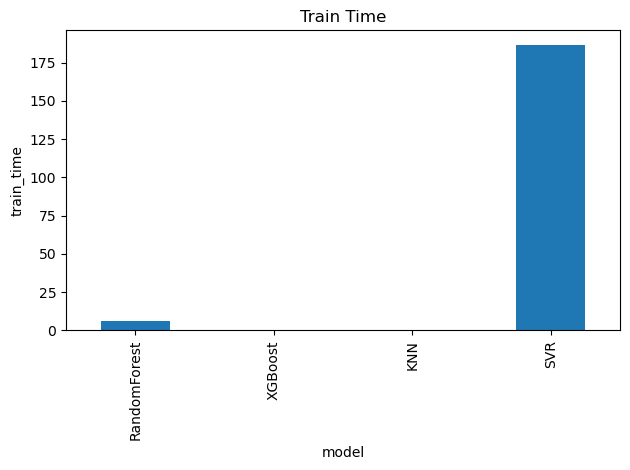

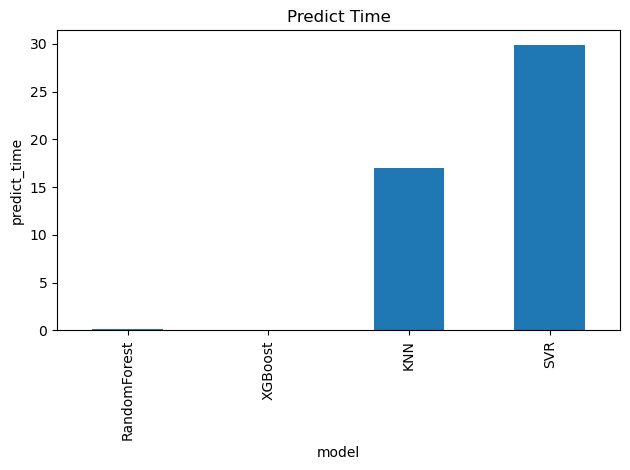

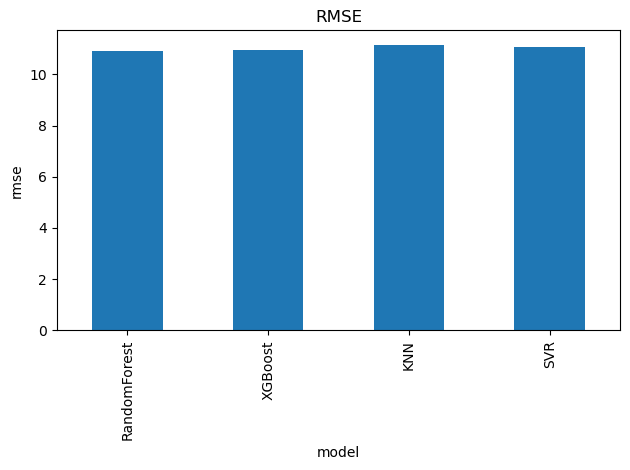

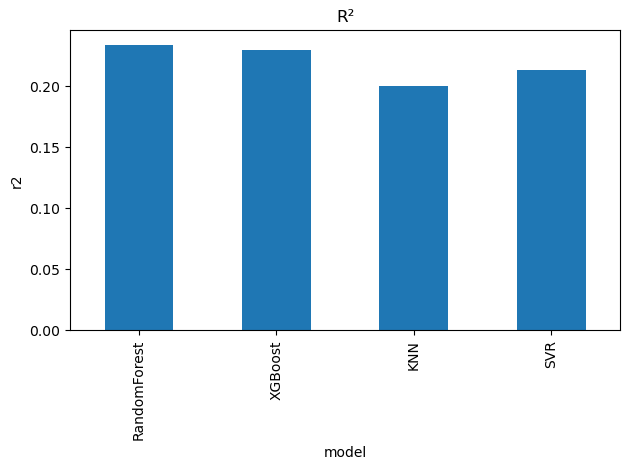

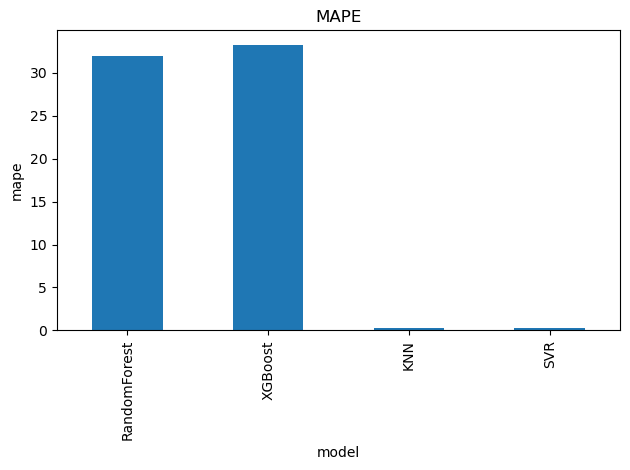

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# 確認 df_final 存在
if "df_final" not in globals():
    raise ValueError("❌ df_final 尚未建立，請先執行你的模型整合程式碼。")

df = df_final.copy()

metrics = {
    "Train Time": "train_time",
    "Predict Time": "predict_time",
    "RMSE": "rmse",
    "R²": "r2",
    "MAPE": "mape"
}

# 逐一繪製五張長條圖
for title, col in metrics.items():
    plt.figure()
    df[col].plot(kind="bar")
    plt.title(title)
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Train_Time.png'

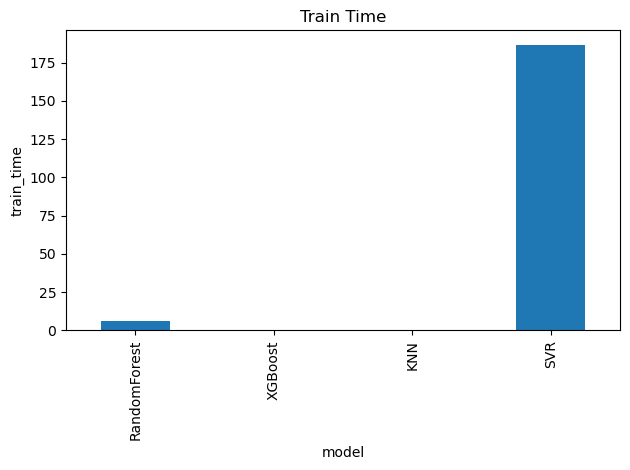

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# 確保 df_final 已存在
if "df_final" not in globals():
    raise ValueError("❌ df_final 不存在，請先執行整合模型程式碼以產生 df_final。")

df = df_final.copy()

metrics = {
    "Train Time": "train_time",
    "Predict Time": "predict_time",
    "RMSE": "rmse",
    "R²": "r2",
    "MAPE": "mape"
}

output_paths = []

# 依序產生 5 張圖並輸出 PNG
for title, col in metrics.items():
    plt.figure()
    df[col].plot(kind="bar")
    plt.title(title)
    plt.ylabel(col)
    plt.tight_layout()
    
    filename = f"{title.replace(' ', '_')}.png"
    filepath = f"/mnt/data/{filename}"
    plt.savefig(filepath)
    plt.close()
    
    output_paths.append(filepath)

output_paths


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# 確保 df_final 存在
if "df_final" not in globals():
    raise ValueError("❌ df_final 不存在，請先執行模型整合程式碼以產生 df_final。")

df = df_final.copy()

metrics = {
    "Train Time": "train_time",
    "Predict Time": "predict_time",
    "RMSE": "rmse",
    "R²": "r2",
    "MAPE": "mape"
}

output_paths = []

# 逐一輸出五張 PNG 到 Notebook 同資料夾
for title, col in metrics.items():
    plt.figure()
    df[col].plot(kind="bar")
    plt.title(title)
    plt.ylabel(col)
    plt.tight_layout()

    # 🔥 存在 Notebook 同資料夾
    filename = f"{title.replace(' ', '_')}.png"
    plt.savefig(filename)
    plt.close()

    output_paths.append(os.path.abspath(filename))

output_paths


['C:\\Users\\USER\\anaconda_projects\\2240fa29-939a-4aae-8b90-795c50567af6\\Train_Time.png',
 'C:\\Users\\USER\\anaconda_projects\\2240fa29-939a-4aae-8b90-795c50567af6\\Predict_Time.png',
 'C:\\Users\\USER\\anaconda_projects\\2240fa29-939a-4aae-8b90-795c50567af6\\RMSE.png',
 'C:\\Users\\USER\\anaconda_projects\\2240fa29-939a-4aae-8b90-795c50567af6\\R².png',
 'C:\\Users\\USER\\anaconda_projects\\2240fa29-939a-4aae-8b90-795c50567af6\\MAPE.png']